# Make orthogonal cross sections 

In [22]:
import cloudComPy as cc # cloud compare python interface.
if cc.isPluginCanupo():
    import cloudComPy.Canupo

if cc.isPluginPCL():
    import cloudComPy.PCL

import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from yaml import load
from yaml.loader import Loader

from helpers.rotation 

In [17]:
# load the different polyline elements. 
BASENAME = "09_GrotteDeVallorbe"
PROCESSING_PARAMS = f"../../real_data/{BASENAME}/params.yaml"
PROCESSING_FP = f"../../real_data/{BASENAME}/process"

params = load(open(PROCESSING_PARAMS), Loader)
GLOBAL_SHIFT = params["alignment"]["globalShift"]

CENTRELINE_FILEPATH = f"../../real_data//process/centrelines/3d/{BASENAME}Centreline_z_interp_3d.poly"

fp_centrelines3D = os.path.join(params["paths"]["root"], params["paths"]["centrelines"], "3d")

centrelines3D = os.listdir(fp_centrelines3D)

PASSAGE = centrelines3D[0].strip(".poly")
centreline = np.loadtxt(os.path.join(fp_centrelines3D, centrelines3D[0])) + GLOBAL_SHIFT

In [5]:
# insert a point in the middle of two.
def expand_ct(centreline, epsilon):
    kmax = 10
    
    k = 0
    while k < kmax:
        k+= 1

        to_insert = np.argwhere(np.linalg.norm(np.diff(centreline, axis = 0), axis = 1) > 1.95*epsilon)

        ls_centreline = list(centreline)

        for idx in to_insert[::-1]:
               # reverse indices so insert from the end does not affect the order. 
            ls_centreline.insert(idx[0]+1, 1/2 * (ls_centreline[idx[0]]+ls_centreline[idx[0]+1]))
        
        centreline = np.vstack(ls_centreline)
    return centreline

In [26]:
expanded  = expand_ct(centreline, 0.4)

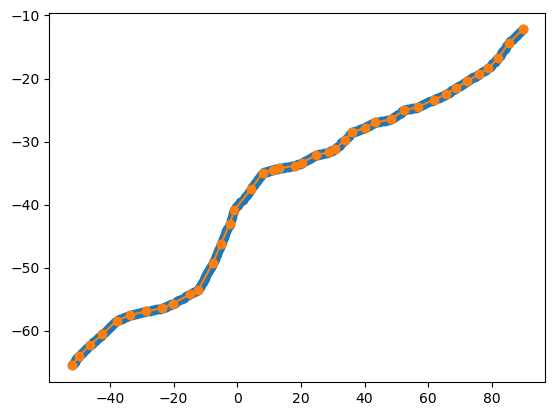

In [27]:
plt.plot(expanded[:, 0], expanded[:, 1], "-o")
plt.plot(centreline[:, 0], centreline[:, 1], "-o")

In [28]:
# define some vectors and their origins 
norms = np.expand_dims(np.linalg.norm(np.diff(expanded, axis = 0), axis = 1), -1)
vecs = np.diff(expanded, axis = 0)  / norms
origins = expanded[:-1]


In [29]:
np.savetxt(os.path.normpath(os.path.join(PROCESSING_FP,  f"planes_as_vectors/{PASSAGE}_Planes.txt")), vecs)
np.savetxt(os.path.normpath(os.path.join(PROCESSING_FP, f"planes_as_vectors/{PASSAGE}_Planes_Origin.txt")), origins - GLOBAL_SHIFT)

In [24]:
def toYParallelMatrix(vec):
    # calculate vector norm 
    norm = vec / np.sqrt(np.sum(vec**2))

    transmat = cc.ccGLMatrix.FromToRotation(list(norm),[0,1,0]) # from Y parallel to Z parallel
    return transmat

def translationToMatrix(vec):
    transmat = np.diag(np.ones(4))
    transmat[:3,3] = vec
    
    transmat = cc.ccGLMatrix(transmat.T.flatten())

    return transmat

In [25]:
total_iterations = len(vecs[2: -2])

for n,vec in tqdm(enumerate(vecs[2: -2]), total = total_iterations):
    # make a plane orthogonal to the Y axis. 
    # first we need a rotation of 90 degrees from Y axis towards the Z axis. 

    tr90 = cc.ccGLMatrix.FromToRotation((0,1,0),(0,0,1))
    
    tr = toYParallelMatrix(vec)
    orig = centreline[n+2]
    translation = translationToMatrix(orig)
    # conceptually. apply transformation to point cloud. 
    # extract a section from a polyline Should be orthogonal to the Yparallel vector, hence possibly just 
    # should the translation also be added ??? 
    # save as a numpy array for the polyline in local coordinates. 
    # apply inverse transformation to the cloud ? 
    mpx = cc.ccGLMatrix(translation*tr.inverse()*tr90)
    mpx2 = cc.ccGLMatrix(translation*tr.inverse()).inverse()
    plane = cc.ccPlane(15, 15, mpx)
    ret = cc.SaveMesh(plane, f"../../re../../real_data/process/{PASSAGE}_Plane_{n}.stl")
    params = cc.Cloud2MeshDistancesComputationParams()
    params.signedDistances = True
    params.octreeLevel = 8

    ret = cc.DistanceComputationTools.computeCloud2MeshDistances(sampleCloud, plane, params)
    sampleCloud.setCurrentScalarField(1)

    sf = sampleCloud.getScalarField(1).toNpArrayCopy()
    slice = sampleCloud.filterPointsByScalarValue(minVal = -0.2, maxVal = 0.2, outside = False)

    sampleCloud.deleteScalarField(1)
    slice.applyRigidTransformation(mpx2)
    slices.append(slice)


  0%|                                                                                          | 0/580 [00:00<?, ?it/s]


NameError: name 'sampleCloud' is not defined

IndexError: list index out of range

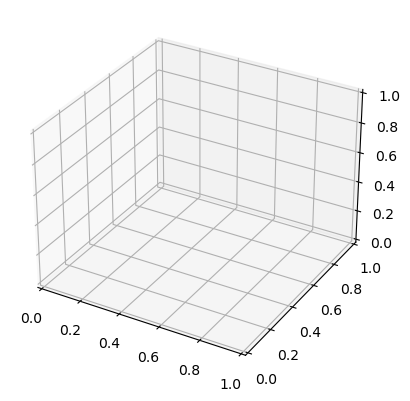

In [60]:
fig = plt.figure()
areas = np.zeros(len(slices))
perimeters = np.zeros(len(slices))

ax = fig.add_subplot(111, projection ="3d")
for n, slice in enumerate(slices):
    out = cc.extractPointsAlongSections([slice], [cut_section_polyline], defaultSectionThickness = 0.1, envelopeMaxEdgeLength = 0.1, extractSectionsAsEnvelopes=True, vertDim = 2, 
                             s_extractSectionsType = cc.EnvelopeType.ENV_FULL)
    section  = out[0].getAssociatedCloud().toNpArrayCopy()
    perimeters[n] = out[0].computeLength()
    x = section[:,0]
    y = section[:,2]
    
    areas[n] = computePolygonArea(x, y)
    ax.plot(section[:,0], np.ones(section.shape[0])*n / 35  * 8, section[:,2],  color = "grey", alpha = 0.25)

plt.show()

In [38]:
Dh = 4 *areas / perimeters

xi = centreline[2:-2,1]

C:\Users\racinet\AppData\Local\Temp\ipykernel_15496\1570580297.py:1: RuntimeWarning: invalid value encountered in true_divide
  Dh = 4 *areas / perimeters


ValueError: x and y must have same first dimension, but have shapes (170,) and (191,)

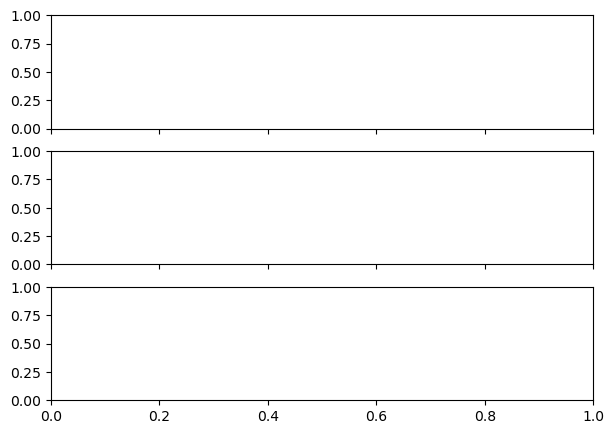

In [39]:
fig, axes = plt.subplots(3, 1, figsize= (7, 5), sharex = True)

axes[0].plot(xi, areas , label = "area")
axes[0].set_ylabel("$A$ [m$^2$]")
#axes[0].text(10, 16, f"$\\bar{{A}}$ = {np.mean(areas[2:-4][15:]):.0f} $\pm${np.std(areas[2:-4][15:]):.0f}")
#axes[0].text(90, 29, f"$\\bar{{A}}$ = {np.mean(areas[2:-4][:15]):.0f} $\pm${np.std(areas[2:-4][:15]):.0f}")
axes[0].set_ylim(13, 37)


axes[1].plot(xi,perimeters, label= "perimeter")
axes[1].set_ylabel("$P$ [m]")
axes[1].set_ylim(14, 46)


axes[2].plot(xi,Dh, label = "Dh")
axes[2].set_ylabel("$D_H$ [m]")
#axes[2].text(10, 2.5, f"$\\bar{{D_H}}$ = {np.mean(Dh[25:]):.1f} $\pm${np.std(Dh[25:]):.1f}")
#axes[2].text(85, 4, f"$\\bar{{D_H}}$ = {np.mean(Dh[:25]):.1f} $\pm${np.std(Dh[:25]):.1f}")
axes[2].set_ylim(1.2, 5.8)

axes[2].set_xlabel("y [m]")


for ax in axes:
    ax.grid()
    #ax.axvline(len(areas[2:-4])-15, ls = "--", color = "firebrick")
plt.tight_layout()

